In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 7.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.

## 1) IMPORTS
    (Load all required Python & ML libraries)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model

2025-12-05 16:58:52.688948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764953932.915636      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764953932.977632      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2) CONFIGURATION / HYPERPARAMETERS
    (Define all tunable settings in one place)

In [3]:
image_size = 64
latent_size = 128
batch_size = 128
epochs = 100
lr = 0.0002

## 3) MODEL DEFINITION – DISCRIMINATOR
    (Define the "critic" that classifies real vs fake images)

In [4]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [5]:
discriminator = build_discriminator()
discriminator.summary()

I0000 00:00:1764953948.937078      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764953948.937690      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,616 (10.56 MB)

 Trainable params: 2,765,696 (10.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

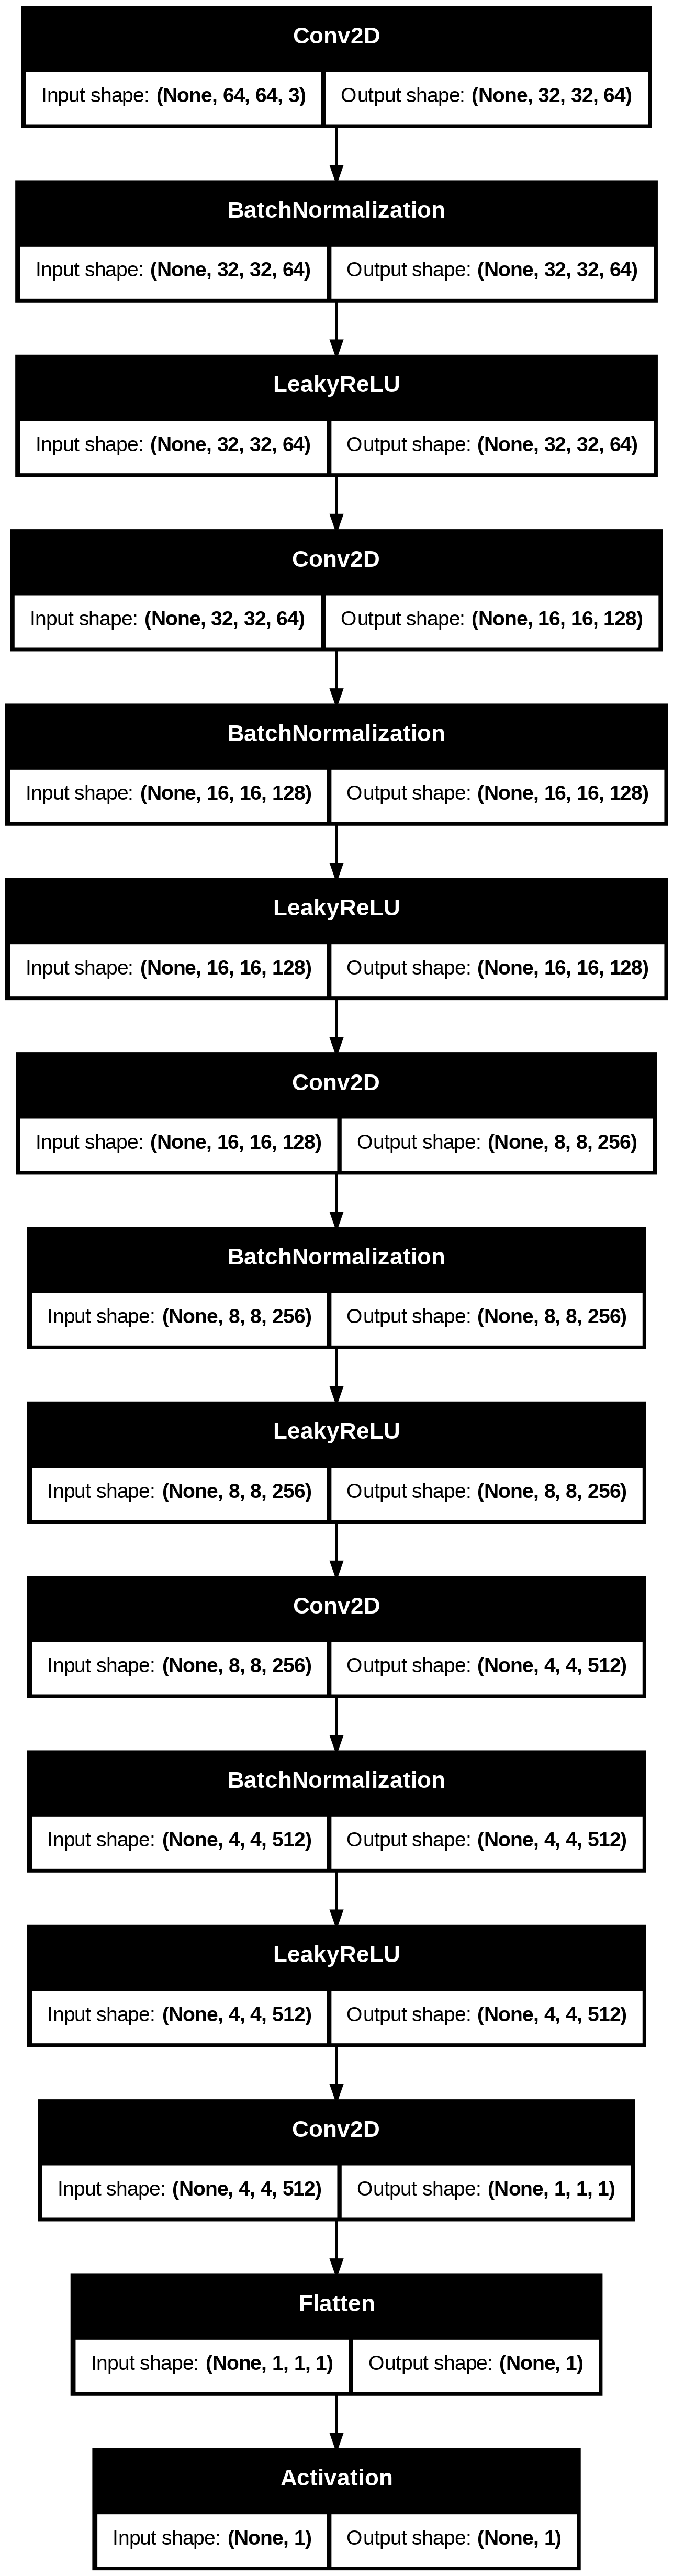

In [29]:
# Visualized Layers of d
tf.keras.utils.plot_model(discriminator, show_shapes=True)

## 4) MODEL DEFINITION – GENERATOR
    (Define the network that maps noise → fake anime images)

In [6]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [7]:
generator = build_generator()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,808,000 (14.53 MB)

 Trainable params: 3,806,080 (14.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

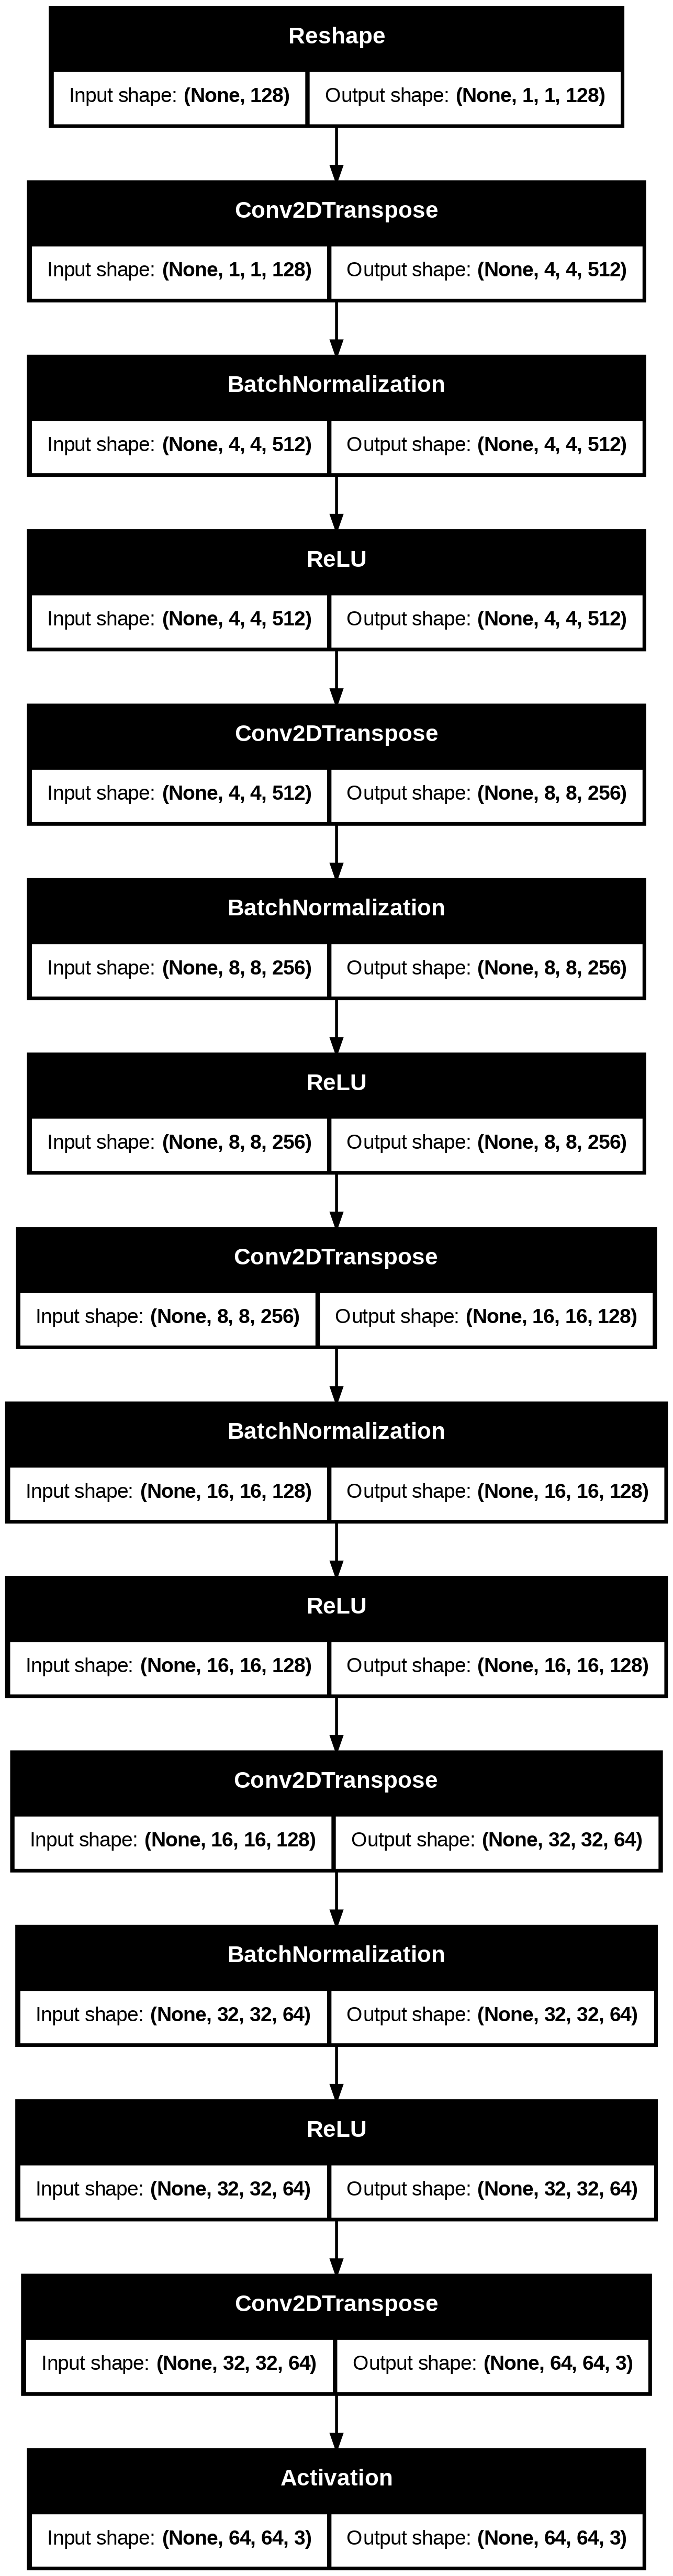

In [30]:
# Visualized Layers of generator
tf.keras.utils.plot_model(generator, show_shapes=True)

## 5) LOSS FUNCTIONS
    (Define how we measure generator & discriminator errors)

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## 6) OPTIMIZERS
    (Define how model parameters are updated each step)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

## 7) ONE TRAINING STEP
    (Single batch update for both generator and discriminator)

In [12]:
@tf.function
def train_step(images):
    # use dynamic batch size instead of global batch_size
    current_bs = tf.shape(images)[0]
    noise = tf.random.normal([current_bs, latent_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # return the losses so we can show them in tqdm
    return gen_loss, disc_loss


## 8) DATA LOADING & PREPROCESSING
    (Load anime face dataset and normalize to [-1, 1])

In [13]:
data_dir = '../input/animefacedataset/'

In [14]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    image_size=(image_size, image_size), 
    batch_size=batch_size, 
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

Found 63565 files.


## 9) CHECKPOINTING
    (Save latest model weights during training)

In [15]:
import os
import tensorflow as tf

# Create checkpoint directory
os.makedirs("checkpoints", exist_ok=True)

checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    g_opt=generator_optimizer,
    d_opt=discriminator_optimizer,
)

manager = tf.train.CheckpointManager(
    checkpoint,
    directory="checkpoints",
    max_to_keep=1   # 🔥 keep ONLY the latest checkpoint
)


## 10) TRAINING LOOP
    (Iterate over epochs & batches, update models, save checkpoints)

In [16]:
from tqdm.auto import tqdm

def train(dataset, epochs, start_epoch=0):
    for epoch in range(start_epoch, start_epoch + epochs):
        pbar = tqdm(dataset, desc=f"Epoch {epoch+1}", unit="batch")

        for images in pbar:
            gen_loss, disc_loss = train_step(images)

            pbar.set_postfix({
                "gen_loss": float(gen_loss.numpy()),
                "disc_loss": float(disc_loss.numpy()),
            })

        # Save last/latest model ONLY
        manager.save()
        print(f"Saved latest checkpoint at epoch {epoch+1}")


In [17]:
train(train_dataset, epochs)

Epoch 1:   0%|          | 0/497 [00:00<?, ?batch/s]

I0000 00:00:1764954117.553109     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


Saved latest checkpoint at epoch 1


Epoch 2:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 2


Epoch 3:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 3


Epoch 4:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 4


Epoch 5:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 5


Epoch 6:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 6


Epoch 7:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 7


Epoch 8:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 8


Epoch 9:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 9


Epoch 10:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 10


Epoch 11:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 11


Epoch 12:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 12


Epoch 13:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 13


Epoch 14:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 14


Epoch 15:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 15


Epoch 16:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 16


Epoch 17:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 17


Epoch 18:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 18


Epoch 19:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 19


Epoch 20:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 20


Epoch 21:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 21


Epoch 22:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 22


Epoch 23:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 23


Epoch 24:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 24


Epoch 25:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 25


Epoch 26:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 26


Epoch 27:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 27


Epoch 28:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 28


Epoch 29:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 29


Epoch 30:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 30


Epoch 31:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 31


Epoch 32:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 32


Epoch 33:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 33


Epoch 34:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 34


Epoch 35:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 35


Epoch 36:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 36


Epoch 37:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 37


Epoch 38:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 38


Epoch 39:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 39


Epoch 40:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 40


Epoch 41:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 41


Epoch 42:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 42


Epoch 43:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 43


Epoch 44:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 44


Epoch 45:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 45


Epoch 46:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 46


Epoch 47:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 47


Epoch 48:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 48


Epoch 49:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 49


Epoch 50:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 50


Epoch 51:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 51


Epoch 52:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 52


Epoch 53:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 53


Epoch 54:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 54


Epoch 55:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 55


Epoch 56:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 56


Epoch 57:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 57


Epoch 58:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 58


Epoch 59:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 59


Epoch 60:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 60


Epoch 61:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 61


Epoch 62:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 62


Epoch 63:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 63


Epoch 64:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 64


Epoch 65:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 65


Epoch 66:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 66


Epoch 67:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 67


Epoch 68:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 68


Epoch 69:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 69


Epoch 70:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 70


Epoch 71:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 71


Epoch 72:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 72


Epoch 73:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 73


Epoch 74:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 74


Epoch 75:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 75


Epoch 76:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 76


Epoch 77:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 77


Epoch 78:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 78


Epoch 79:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 79


Epoch 80:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 80


Epoch 81:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 81


Epoch 82:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 82


Epoch 83:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 83


Epoch 84:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 84


Epoch 85:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 85


Epoch 86:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 86


Epoch 87:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 87


Epoch 88:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 88


Epoch 89:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 89


Epoch 90:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 90


Epoch 91:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 91


Epoch 92:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 92


Epoch 93:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 93


Epoch 94:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 94


Epoch 95:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 95


Epoch 96:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 96


Epoch 97:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 97


Epoch 98:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 98


Epoch 99:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 99


Epoch 100:   0%|          | 0/497 [00:00<?, ?batch/s]

Saved latest checkpoint at epoch 100


## 11) (OPTIONAL) LOSS HISTORY & VISUALIZATION
     (If you logged losses during training)

In [33]:
g_loss_history = [5.31, 1.25, 1.27, 2.45, 3.91, 1.73, 2.49, 4.14, 6.74, 3.98, 5.66, 3.47, 
                  3.77, 1.6, 3.05, 2.75, 0.475, 2.59, 3.57, 3.78, 3.12, 5.46, 3.47, 3.85, 
                  2.61, 3.58, 2.38, 2.44, 3.56, 4.63, 1.98, 4.07, 3.67, 4.91, 3.82, 5.06, 
                  4.81, 2.81, 3.39, 4.26, 5.8, 4.73, 3.27, 4.95, 5.44, 9.32, 4.88, 5.98, 
                  3.95, 5.04, 3.55, 5.87, 3.6, 2.74, 4.66, 2.72, 5.14, 5.67, 4.4, 5.33, 
                  3.31, 4.27, 6.41, 5.32, 5.04, 4.84, 5.62, 6.08, 4.33, 3.82, 5.9, 6.06,
                  3.98, 7.91, 4.58, 6.44, 4.53, 9.17, 11.7, 5.52, 6.74, 5.14, 3.33, 3.78, 
                  4.35, 4.51, 4.71, 4.62, 5.87, 4.73, 4.63, 2.94, 3.23, 5.5, 4.24, 6.18, 
                  5.25, 7.44, 6.53, 9.27]
d_loss_history = [1.09, 0.649, 0.589, 0.308, 0.392, 0.463, 0.214, 0.315, 0.321, 0.0639, 
                  0.0952, 0.15, 0.0683, 0.549, 0.183, 0.161, 1.62, 0.255, 0.0856, 0.113, 
                  0.221, 0.238, 0.135, 0.199, 0.177, 0.113, 0.21, 0.278, 0.0888, 0.0663, 
                  0.357, 0.0783, 0.0921, 0.0929, 0.059, 0.15, 0.116, 0.212, 0.165, 0.0628, 
                  0.391, 0.0549, 0.126, 0.0203, 0.0394, 0.0527, 0.0537, 0.028, 0.136, 0.0281, 
                  0.119, 0.0235, 0.0727, 0.275, 0.0435, 0.486, 0.143, 0.05, 0.0813, 0.0266, 
                  0.133, 0.0551, 0.00707, 0.0366, 0.0955, 0.0208, 0.196, 0.0739, 0.102, 0.0703, 
                  0.0169, 0.0508, 0.112, 0.023, 0.0531, 0.0282, 0.0864, 0.166, 2.78, 0.024, 
                  0.0228, 0.0352, 0.134, 0.0836, 0.0463, 0.0621, 0.0465, 0.0465, 0.107, 0.0944, 
                  0.0739, 0.251, 0.155, 0.0341, 0.0539, 0.0291, 0.0183, 0.0701, 0.00688, 0.00074]

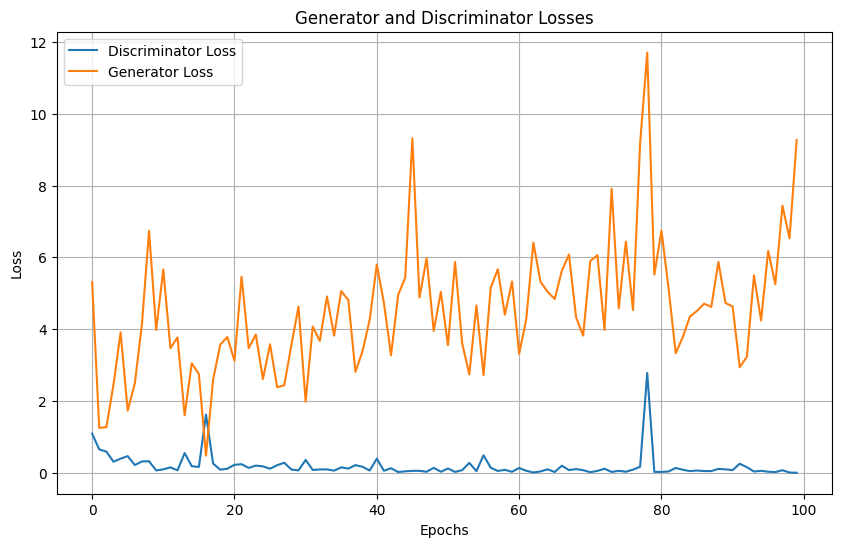

In [34]:
import matplotlib.pyplot as plt

def create_loss_figure(d_loss_values, g_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_history, label='Discriminator Loss')
    plt.plot(g_loss_history, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

create_loss_figure(d_loss_history, g_loss_history)


In [45]:
generator.save("generator_model.keras")
discriminator.save("discriminator_model.keras")

In [26]:
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

## 12) MODEL INFERENCE – GENERATE NEW IMAGES
     (Use the trained generator to create anime characters)

In [43]:
num_samples = 9
sample_noise = tf.random.normal([num_samples, latent_size])
sample_images = generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5  # Denormalize
sample_images = np.clip(sample_images, 0, 1)  # Clip values to [0, 1]

## 13) VISUALIZE GENERATED SAMPLES

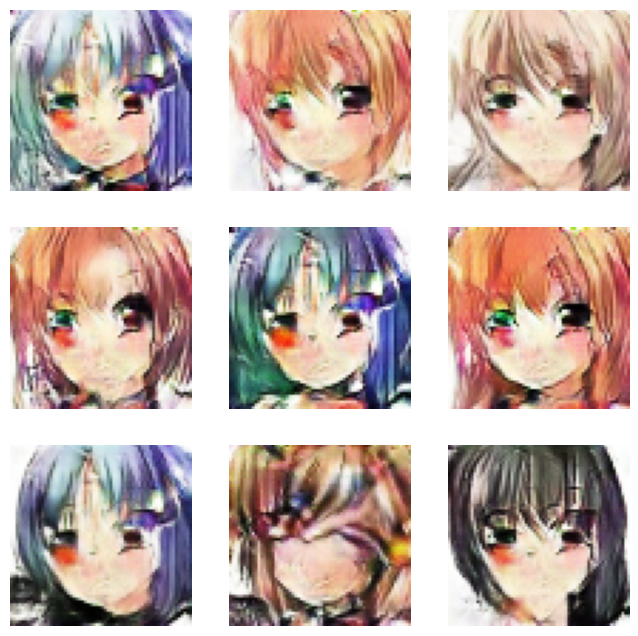

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.show()